# Sanity check for the training and testing data

In [17]:
import os, random, json
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = r"E:\FineTuning\data"  # <-- change if needed
TRAIN_PATH = os.path.join(DATA_DIR, "train.jsonl")
VAL_PATH   = os.path.join(DATA_DIR, "val.jsonl")

print("Train path:", TRAIN_PATH)
print("Val path  :", VAL_PATH)

# Read JSONL files
train_df = pd.read_json(TRAIN_PATH, lines=True)
val_df   = pd.read_json(VAL_PATH, lines=True)

print(f"Loaded: {len(train_df)} train rows, {len(val_df)} val rows")
train_df.head(3)

Train path: E:\FineTuning\data\train.jsonl
Val path  : E:\FineTuning\data\val.jsonl
Loaded: 2379 train rows, 500 val rows


,instruction,input,output
0,You are an intelligent Python coding assistant...,You are given a Python function signature and ...,"sum(d * 10 ** i for i, d in enumerate(x[::-1]))"
1,You are an intelligent Python coding assistant...,You are given a Python function signature and ...,"r = int(''.join(map(str, x)))"
2,You are an intelligent Python coding assistant...,You are given a Python function signature and ...,datetime.strptime('2010-11-13 10:33:54.227806'...


In [18]:
train_df.iloc[1]['input']

'You are given a Python function signature and docstring.\nWrite the COMPLETE function, starting with the `def ...:` line.\nReturn ONLY the code (no comments, no backticks, no extra text).\nFunction to implement:\nHow to convert a list of multiple integers into a single integer?\n'

## Random samples

In [5]:
def show_samples(df, n=3, seed=42):
    random.seed(seed)
    idxs = random.sample(range(len(df)), k=min(n, len(df)))
    for i, idx in enumerate(idxs, 1):
        row = df.iloc[idx]
        print(f"\n=== Sample {i} (row {idx}) ===")
        print("Instruction:\n", row.get("instruction","").strip())
        print("\nInput (NL):\n", row.get("input","").strip())
        print("\nOutput (Python):\n")
        print(row.get("output","").strip())
        print("="*60)

show_samples(train_df, n=3, seed=123)


=== Sample 1 (row 6863) ===
Instruction:
 You are an expert in Python. Please write clean and readable Python code that satisfies the intent.

Input (NL):
 Reorganize a CSV so Dates are not column Headers

Output (Python):

lines = [line.split(',') for line in content.split('\n')]

=== Sample 2 (row 35084) ===
Instruction:
 You are an expert in Python. Please write clean and readable Python code that satisfies the intent.

Input (NL):
 How to convert signed to unsigned integer in python

Output (Python):

-1
_ + 2 ** 32
bin(_)

=== Sample 3 (row 11427) ===
Instruction:
 You are an expert in Python. Please write clean and readable Python code that satisfies the intent.

Input (NL):
 Login to website using python

Output (Python):

r = session.post(URL, data=login_data)
r = session.get('http://friends.cisv.org/index.cfm?fuseaction=user.fullprofile'
    )
if __name__ == '__main__':
    main()


## Basic validation checks

In [6]:
def basic_checks(df, name="df"):
    missing_output = (df["output"].astype(str).str.strip() == "").sum()
    missing_input  = (df["input"].astype(str).str.strip() == "").sum()
    missing_instr  = (df["instruction"].astype(str).str.strip() == "").sum()
    print(f"[{name}] rows: {len(df)}")
    print(f"[{name}] empty output: {missing_output}")
    print(f"[{name}] empty input : {missing_input}")
    print(f"[{name}] empty instr : {missing_instr}")

basic_checks(train_df, "train")
basic_checks(val_df,   "val")

[train] rows: 102314
[train] empty output: 0
[train] empty input : 0
[train] empty instr : 0
[val] rows: 500
[val] empty output: 0
[val] empty input : 0
[val] empty instr : 0


## Length stats and simple histogram

        output_chars   output_lines
count  102314.000000  102314.000000
mean       68.896417       2.294867
std        94.021791       2.637764
min         1.000000       1.000000
25%        25.000000       1.000000
50%        42.000000       1.000000
75%        75.000000       2.000000
max      5730.000000      83.000000


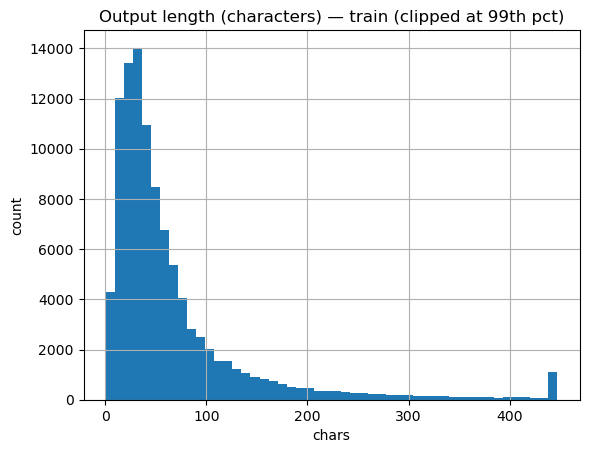

In [7]:
def add_length_stats(df):
    df = df.copy()
    df["output_chars"] = df["output"].astype(str).str.len()
    df["output_lines"] = df["output"].astype(str).str.count(r"\n") + 1
    return df

train_stats = add_length_stats(train_df)
print(train_stats[["output_chars","output_lines"]].describe())

plt.figure()
train_stats["output_chars"].clip(upper=train_stats["output_chars"].quantile(0.99)).hist(bins=50)
plt.title("Output length (characters) — train (clipped at 99th pct)")
plt.xlabel("chars")
plt.ylabel("count")
plt.show()